In [1]:
import numpy as np

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks.early_stopping import EarlyStopping


from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Subset

from deeptime.data import BaseDataset, UCRDataset
from deeptime.models.representation.inception import InceptionAutoEncoder

C:\Users\medei\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_dataset = UCRDataset(name='FordA', split='train')
len(train_dataset)

3601

In [3]:
test_dataset = UCRDataset(name='FordA', split='test')
len(test_dataset)

1320

In [4]:
unique_labels = torch.unique(train_dataset[:][1])
unique_labels

tensor([-1.,  1.])

In [5]:
for label in unique_labels:
    x_train, y_train = train_dataset[label == train_dataset[:][1]]

    filtered_dataset = BaseDataset(
        x=np.array(x_train.tolist()),
        y=np.array(y_train.tolist())
    )

    train_loader = DataLoader(filtered_dataset, batch_size=16)

    autoencoder = InceptionAutoEncoder(
        num_blocks=3,
        in_features=500,
        in_channels=1,
        out_channels=128,
        bottleneck_channels=32,
        kernel_sizes=41,
    )
    trainer = pl.Trainer(
        max_epochs=500,
        accelerator='gpu',
        devices=-1,
        callbacks=[EarlyStopping(monitor='train_loss', mode='min', patience=10, min_delta=0.01)]
    )
    trainer.fit(model=autoencoder, train_dataloaders=train_loader)
    break

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | e_blocks | Sequential | 2.0 M 
1 | e_head   | Sequential | 16.4 M
2 | d_blocks | Sequential | 1.3 M 
3 | d_head   | Sequential | 16.4 M
----------------------------------------
36.2 M    Trainable params
0         Non-trainable params
36.2 M    Total params
144.782   Total estimated model params size (MB)
C:\Users\medei\AppData\Local\Programs\Python\Python39\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_wa

Epoch 48: 100%|███████████████████████████████████████████████| 116/116 [00:11<00:00,  9.99it/s, loss=0.0692, v_num=12]


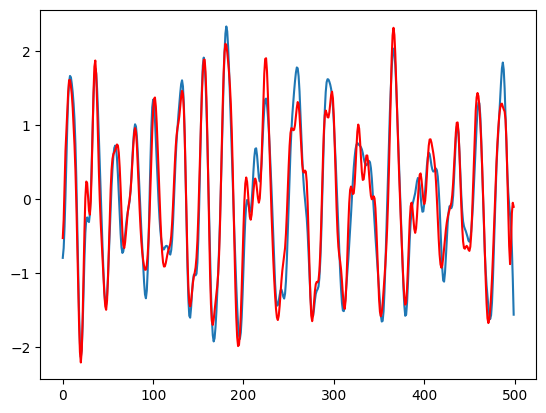

In [6]:
import matplotlib.pyplot as plt

x_hat, z = autoencoder(train_dataset[:1][0])

plt.plot(list(range(500)), train_dataset[0][0].view(-1).tolist())
plt.plot(list(range(500)), x_hat.view(-1).tolist(), color='red')